In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

In [2]:
predictions_df = pd.read_csv("predictions.csv")

In [3]:
display(predictions_df)

,groundtruth,knn,knn_bw,knn_pca,knn_bw_pca,lr,lr_bw,lr_pca,lr_bw_pca,rf,rf_bw,rf_pca,rf_bw_pca
0,airplane,airplane,ship,airplane,airplane,airplane,ship,airplane,ship,ship,ship,airplane,ship
1,airplane,airplane,airplane,airplane,bird,ship,cat,ship,cat,ship,airplane,airplane,frog
2,airplane,airplane,airplane,airplane,airplane,airplane,airplane,airplane,airplane,airplane,airplane,bird,airplane
3,airplane,truck,ship,truck,ship,bird,airplane,bird,airplane,horse,horse,bird,truck
4,airplane,ship,ship,airplane,ship,airplane,cat,airplane,frog,airplane,bird,ship,deer
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,truck,airplane,airplane,airplane,airplane,airplane,airplane,airplane,airplane,airplane,airplane,truck,airplane
9996,truck,ship,ship,ship,ship,truck,truck,truck,truck,ship,ship,truck,ship
9997,truck,truck,truck,truck,truck,truck,truck,truck,truck,truck,truck,truck,truck
9998,truck,frog,deer,frog,deer,automobile,automobile,automobile,automobile,truck,truck,automobile,automobile


In [4]:
models_name = list(predictions_df.columns)
models_name.remove("groundtruth")

# Models metrics
We compute accuracy, precision, recall and F1 score for each model. We compute also F1 score global.

Accuracy score is equal to recall score because the number of elements is equal for each category in the training set (1000 per category).

In [5]:
metrics_df = dict()
for m in models_name:
    # Compute metrics for each model
    y_true = predictions_df["groundtruth"]
    y_pred = predictions_df[m]
    accuracy = accuracy_score(y_true=y_true, y_pred=y_pred)
    precision = precision_score(y_true=y_true, y_pred=y_pred, average="macro")
    recall = recall_score(y_true=y_true, y_pred=y_pred, average="macro")
    f1 = f1_score(y_true=y_true, y_pred=y_pred, average="macro")
    f1_glob = (2 * precision * recall) / (precision + recall)
    series = pd.Series(name=m,
                       index=["accuracy", "precision_macro", "recall_macro", "f1_macro", "f1_global"],
                       data=[accuracy, precision, recall, f1, f1_glob])
    metrics_df[m] = series
metrics_df = pd.DataFrame(metrics_df)

In [6]:
display(metrics_df)

,knn,knn_bw,knn_pca,knn_bw_pca,lr,lr_bw,lr_pca,lr_bw_pca,rf,rf_bw,rf_pca,rf_bw_pca
accuracy,0.354700,0.308400,0.381100,0.332300,0.397900,0.277900,0.406100,0.305300,0.467400,0.413900,0.433800,0.372500
precision_macro,0.455384,0.422896,0.458007,0.427422,0.395960,0.272077,0.401039,0.299176,0.462624,0.410471,0.428686,0.369821
recall_macro,0.354700,0.308400,0.381100,0.332300,0.397900,0.277900,0.406100,0.305300,0.467400,0.413900,0.433800,0.372500
f1_macro,0.342898,0.294861,0.374606,0.324220,0.396352,0.273963,0.402188,0.300276,0.463454,0.410695,0.429741,0.369893
f1_global,0.398785,0.356685,0.416029,0.373906,0.396928,0.274958,0.403554,0.302207,0.465000,0.412178,0.431228,0.371156


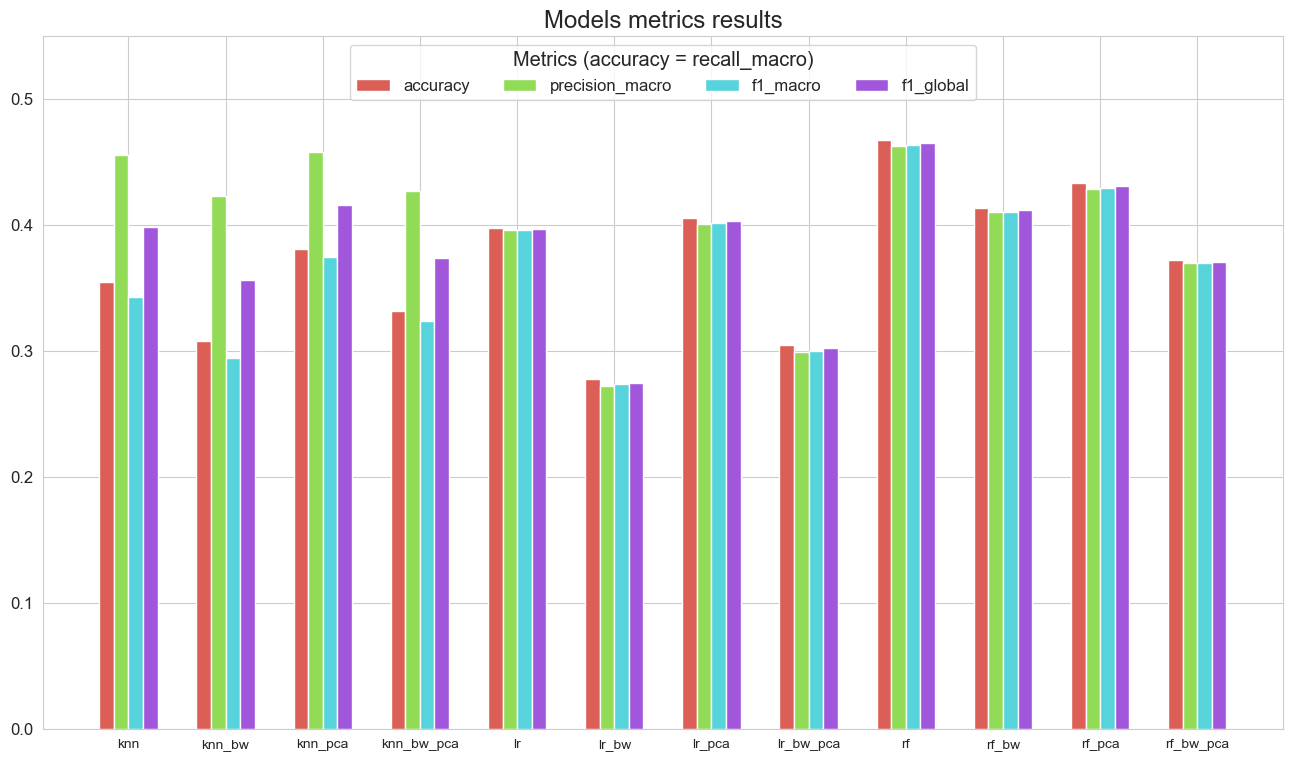

In [7]:
sns.set_style("whitegrid")
palette = sns.color_palette("hls", 4)
sns.set_palette(palette)

metrics_dict = {metric: list(metrics_df.T[metric]) for metric in ["accuracy", "precision_macro", "f1_macro", "f1_global"]}

x = np.arange(len(models_name))
width = 0.15
multiplier = -0.5

fig, ax = plt.subplots(figsize=(16, 9))

for metric, value in metrics_dict.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, value, width, label=metric)
    #ax.bar_label(rects, padding=4)
    multiplier = multiplier + 1

ax.set_title("Models metrics results", fontsize="xx-large")
ax.set_xticks(x + width, models_name, fontsize="medium")
ax.legend(loc="upper center", ncol=4, fontsize="large", title="Metrics (accuracy = recall_macro)", title_fontsize="x-large")
ax.set_ylim(0, 0.55)
plt.setp(ax.get_yticklabels(), fontsize="large")
plt.show()

Black and white models have worse performance than RGB models.

PCA increased performance with KNN and Logistic Regression.

Best models are: knn_pca, lr_pca, rf, rf_bw, rf_pca.

# Predictions similarity
Know we compute the prediction similarity among models in the following way:
$$
\text{similarity} = \dfrac{\text{images predicted in the same way}}{\text{total images}}.
$$
It is easy to compute similarity by using accuracy score.

NB: similarity increases also when two models predict wrong but in the same way.

In [8]:
similarity_matrix = np.eye(len(models_name))
for i in range(similarity_matrix.shape[0]):
    model_i = models_name[i]
    for j in range(similarity_matrix.shape[1]):
        model_j = models_name[j]
        similarity_value = round(accuracy_score(predictions_df[model_i], predictions_df[model_j]), 2)
        similarity_matrix[i, j] = similarity_value

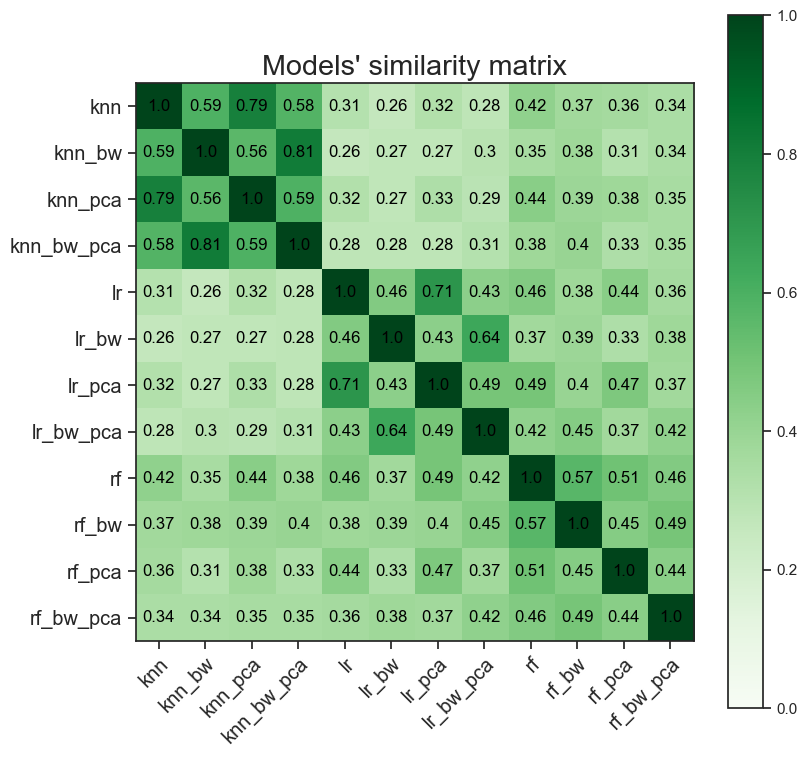

In [9]:
sns.set_theme(style="ticks")

fig, ax = plt.subplots(figsize=(9, 9))
im = ax.imshow(similarity_matrix, cmap="Greens", vmin=0, vmax=1)
cbar = ax.figure.colorbar(im, ax=ax)

ax.set_xticks(np.arange(len(models_name)), models_name, fontsize="large")
ax.set_yticks(np.arange(len(models_name)), models_name, fontsize="large")
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Add numbers
for i in range(similarity_matrix.shape[0]):
    for j in range(similarity_matrix.shape[1]):
        text = ax.text(j, i, similarity_matrix[i, j], ha="center", va="center", color="black", fontsize="medium")
        
ax.set_title("Models' similarity matrix", fontsize="xx-large")
#fig.tight_layout()

plt.show()

It's easy to see how models of the same family are more similar between each other.

# Confusion matrices
We will plot confusion matrix of each model.

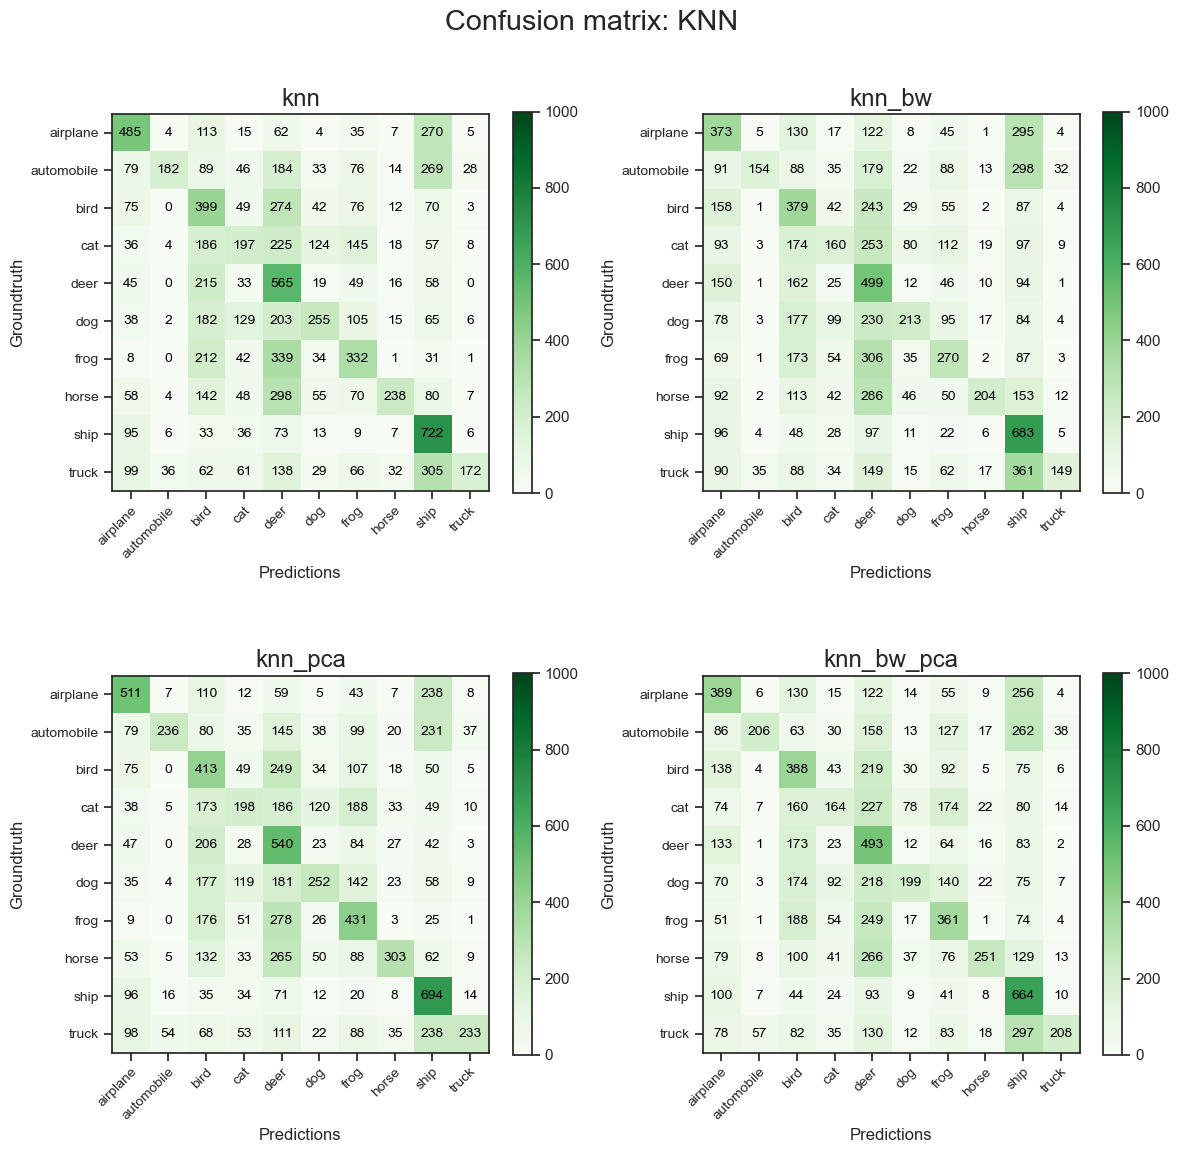

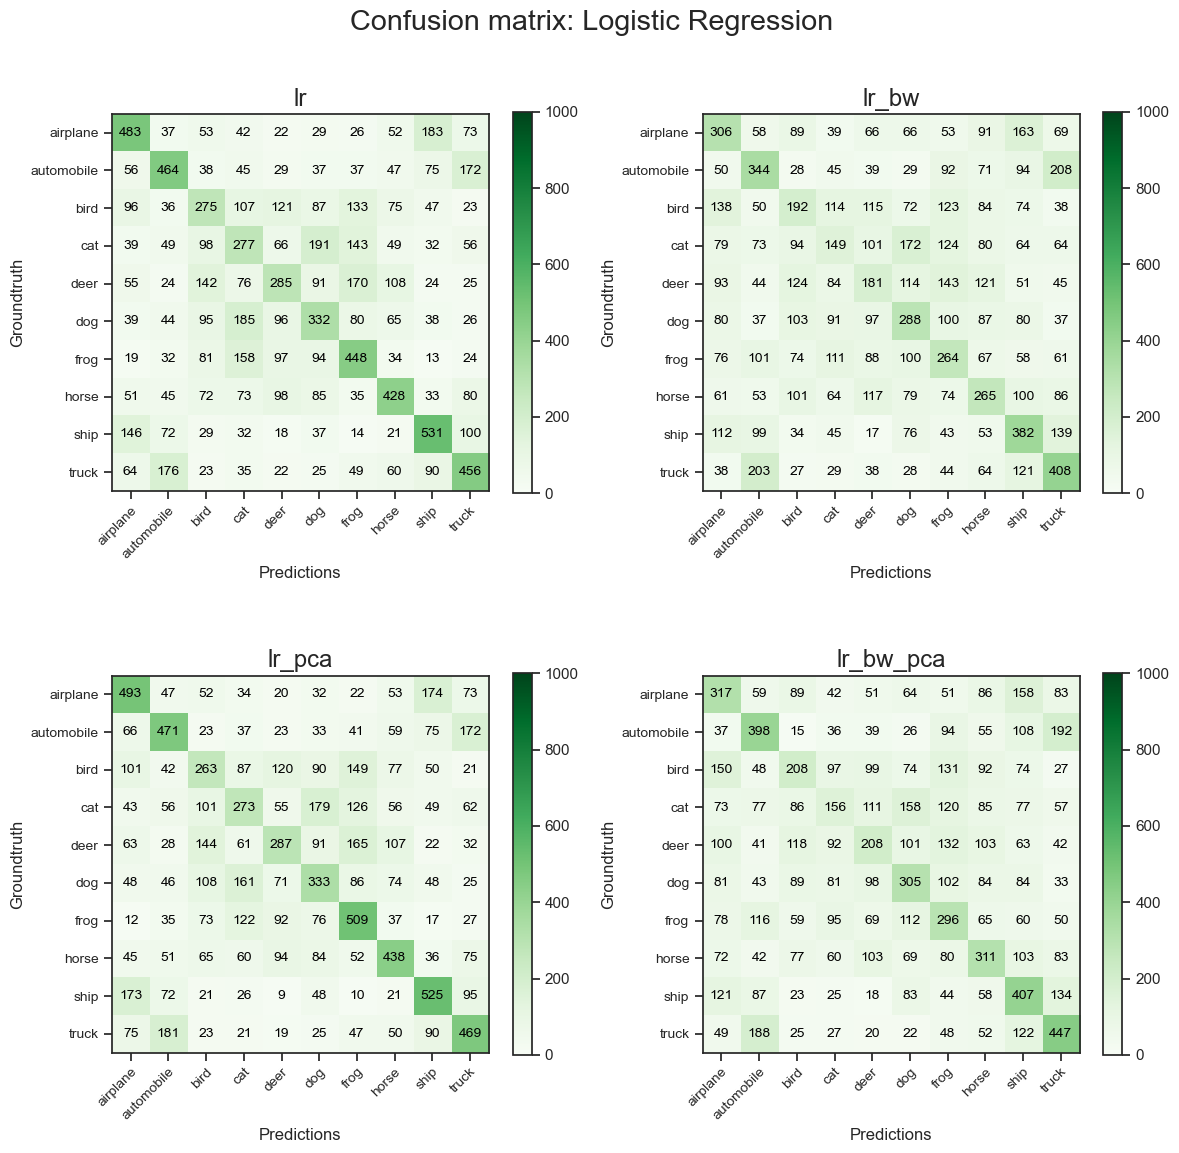

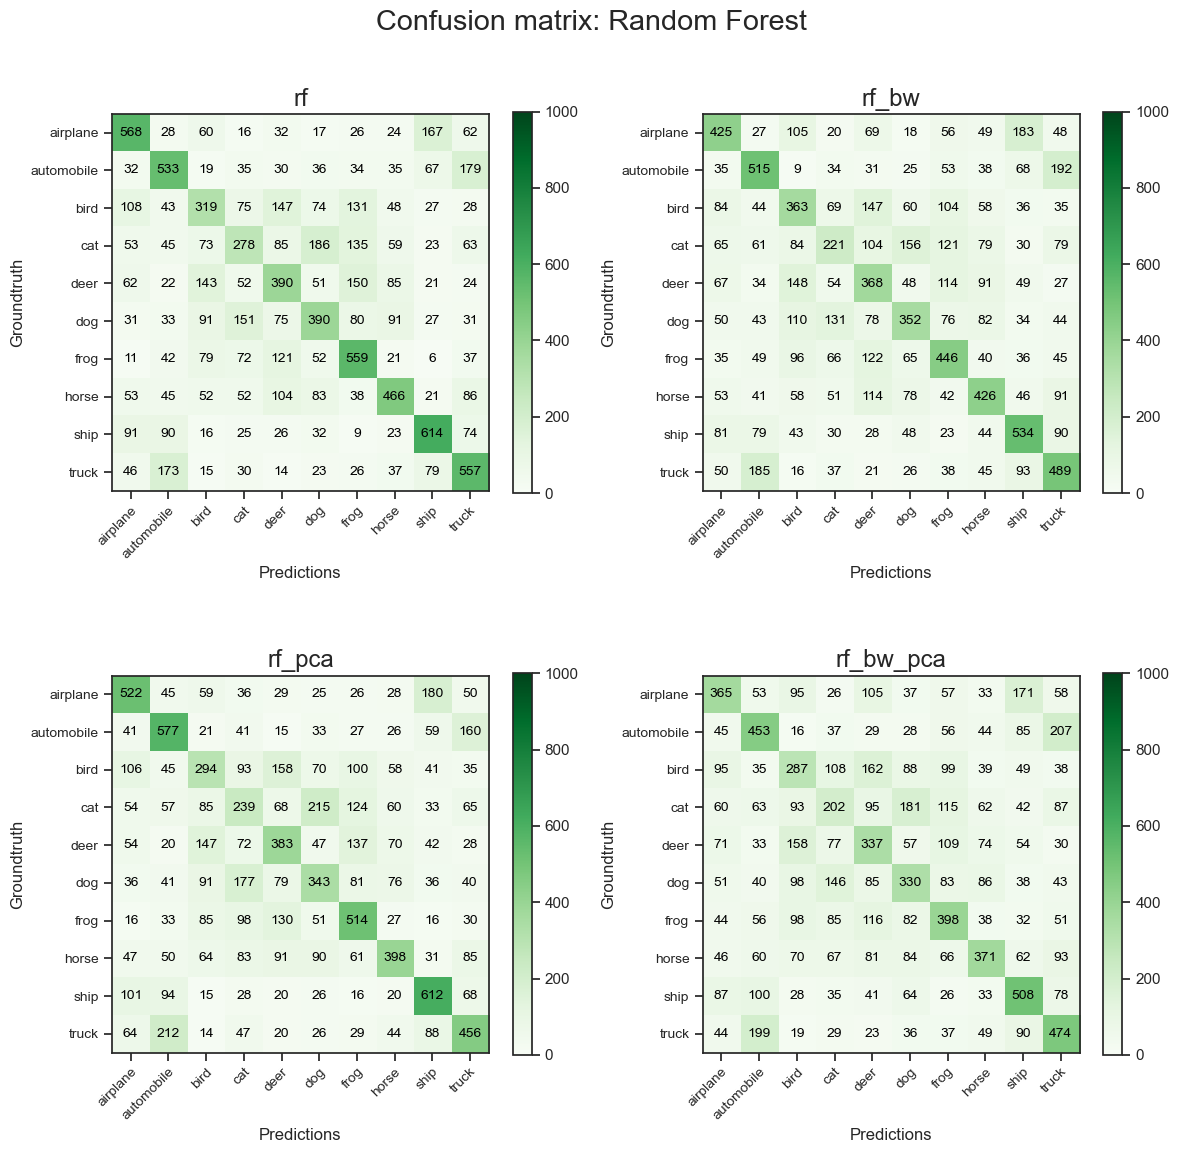

In [10]:
for models_list, title in zip([models_name[: 4], models_name[4: 8], models_name[8: ]],
                              ["KNN", "Logistic Regression", "Random Forest"]):

    categories = predictions_df["groundtruth"].unique()

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 12), tight_layout=True)

    for ax, model in zip([ax1, ax2, ax3, ax4], models_list):
        ax.set_title(model, fontsize="x-large")
        cm = confusion_matrix(y_true=predictions_df["groundtruth"], y_pred=predictions_df[model])

        im = ax.imshow(cm, cmap="Greens", vmin=0, vmax=1000)
        cbar = ax.figure.colorbar(im, ax=ax, shrink=0.75)

        ax.set_xticks(np.arange(len(categories)), categories, fontsize="small")
        ax.set_yticks(np.arange(len(categories)), categories, fontsize="small")
        ax.set_xlabel("Predictions", fontsize="medium")
        ax.set_ylabel("Groundtruth", fontsize="medium")
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

        # Add numbers
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                text = ax.text(j, i, cm[i, j], ha="center", va="center", color="black", fontsize="small")

    fig.suptitle("Confusion matrix: " + title, fontsize="xx-large")
plt.show()    

# Metrics for each category (label)

In [11]:
categories = list(predictions_df["groundtruth"].unique())
cat_dict = dict()
for category in categories:
    cat_index = categories.index(category)
    # Compute precision, recall and f1 score for every model
    m_dict = dict()
    for model in models_name:
        # Create confusion matrix
        cm = confusion_matrix(predictions_df["groundtruth"], predictions_df[model])
        TP = cm[cat_index, cat_index]
        FN_TP = cm[cat_index, :].sum()    # Sum of the row (in our case is always 1000)
        FP_TP = cm[:, cat_index].sum()    # Sum of the column
        precision = TP / FP_TP
        recall = TP / FN_TP
        f1_score = (2 * precision * recall) / (precision + recall)
        m_dict[model] = {"precision": precision, "recall": recall, "f1_score": f1_score}
    cat_dict[category] = m_dict

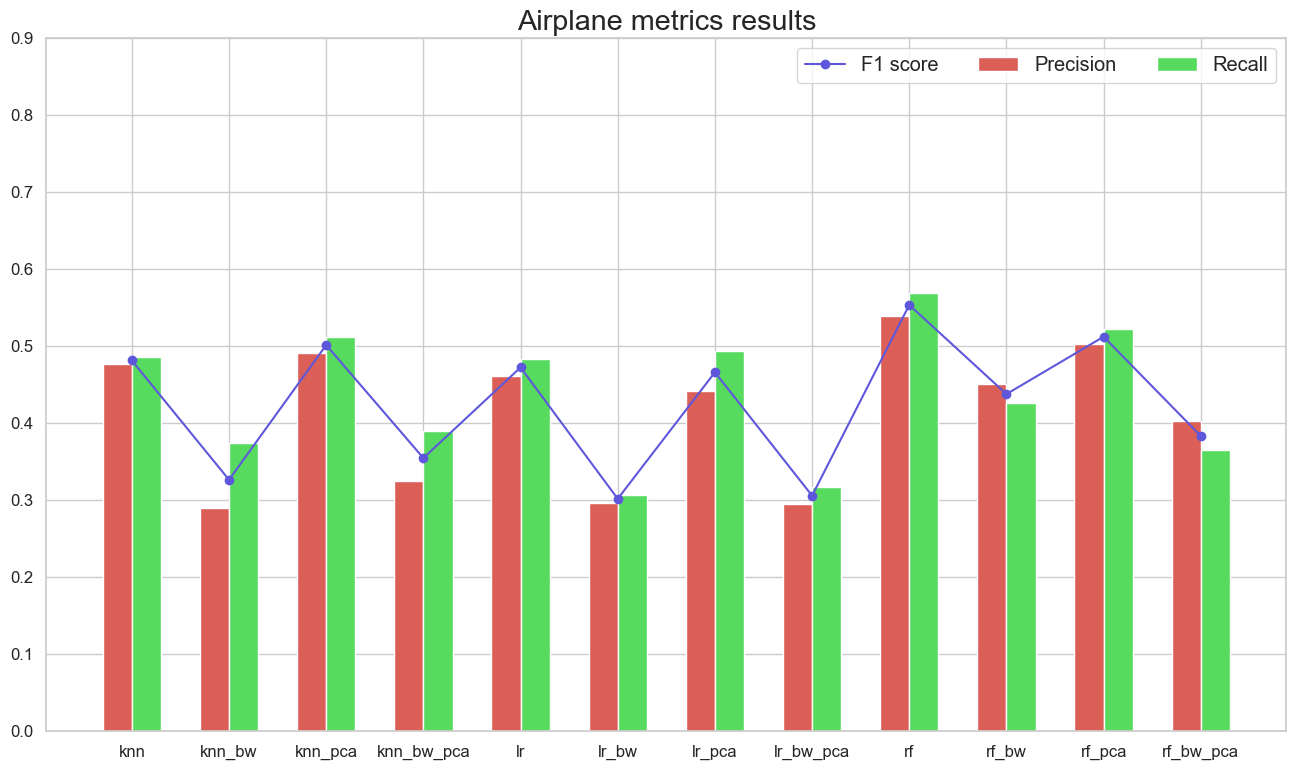

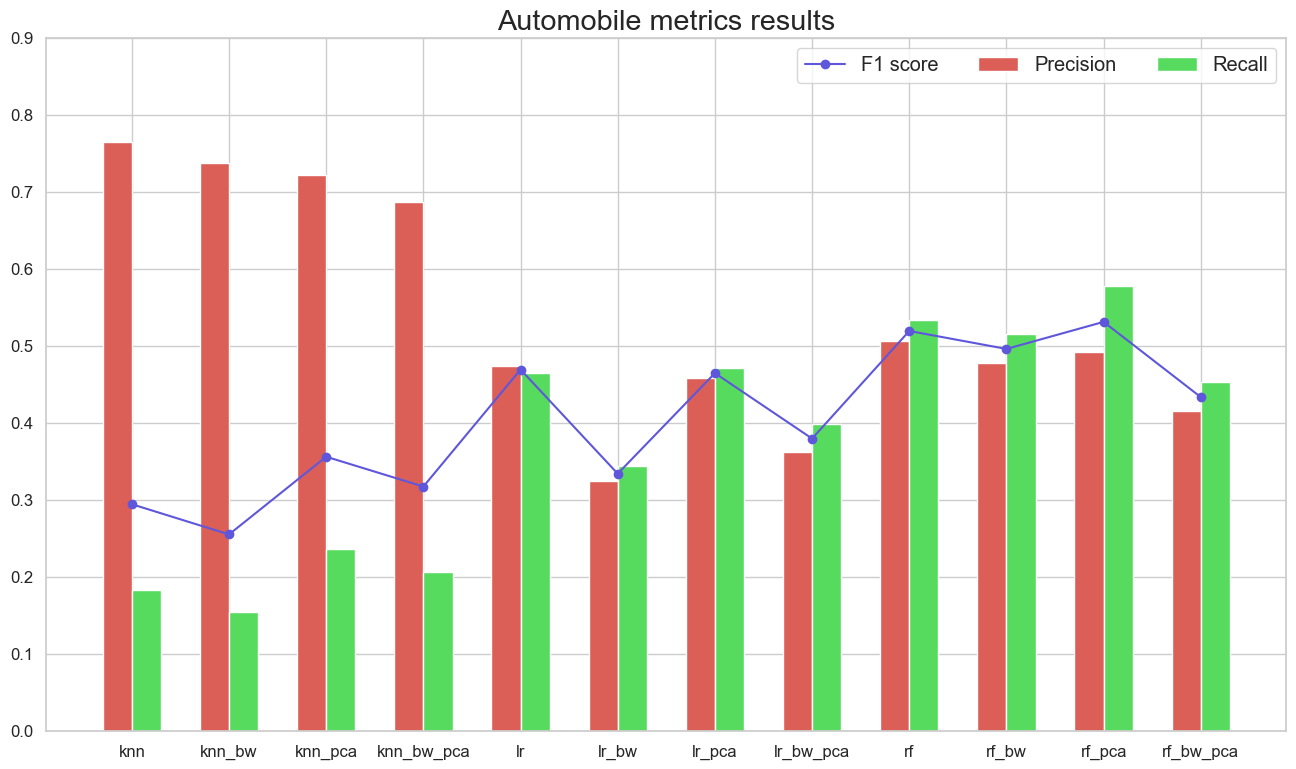

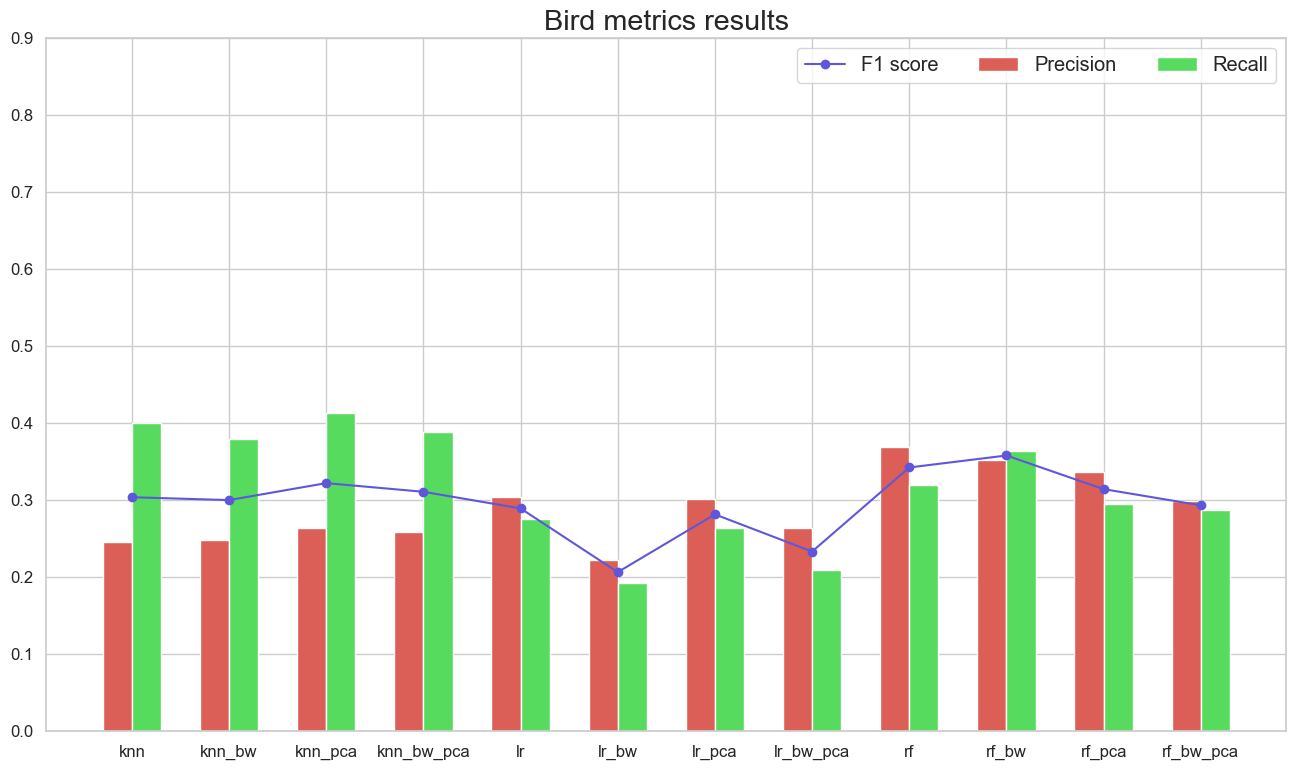

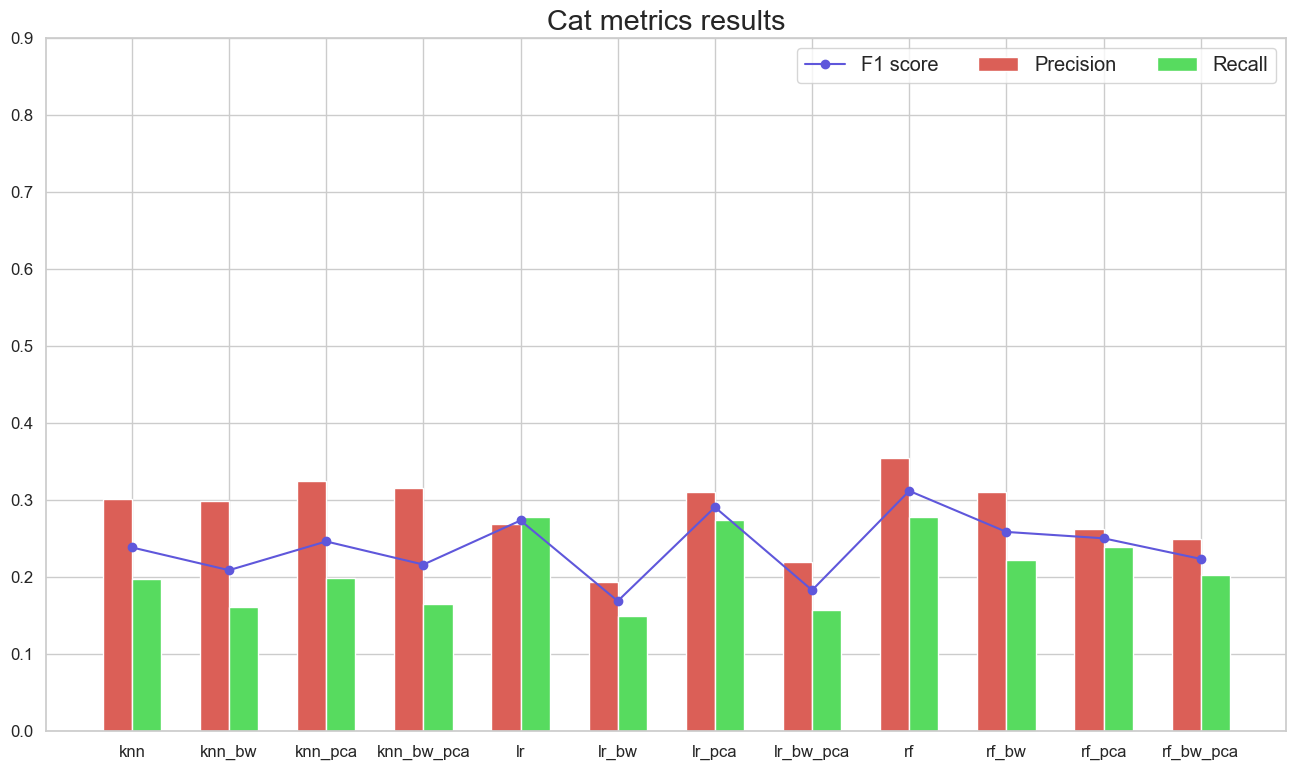

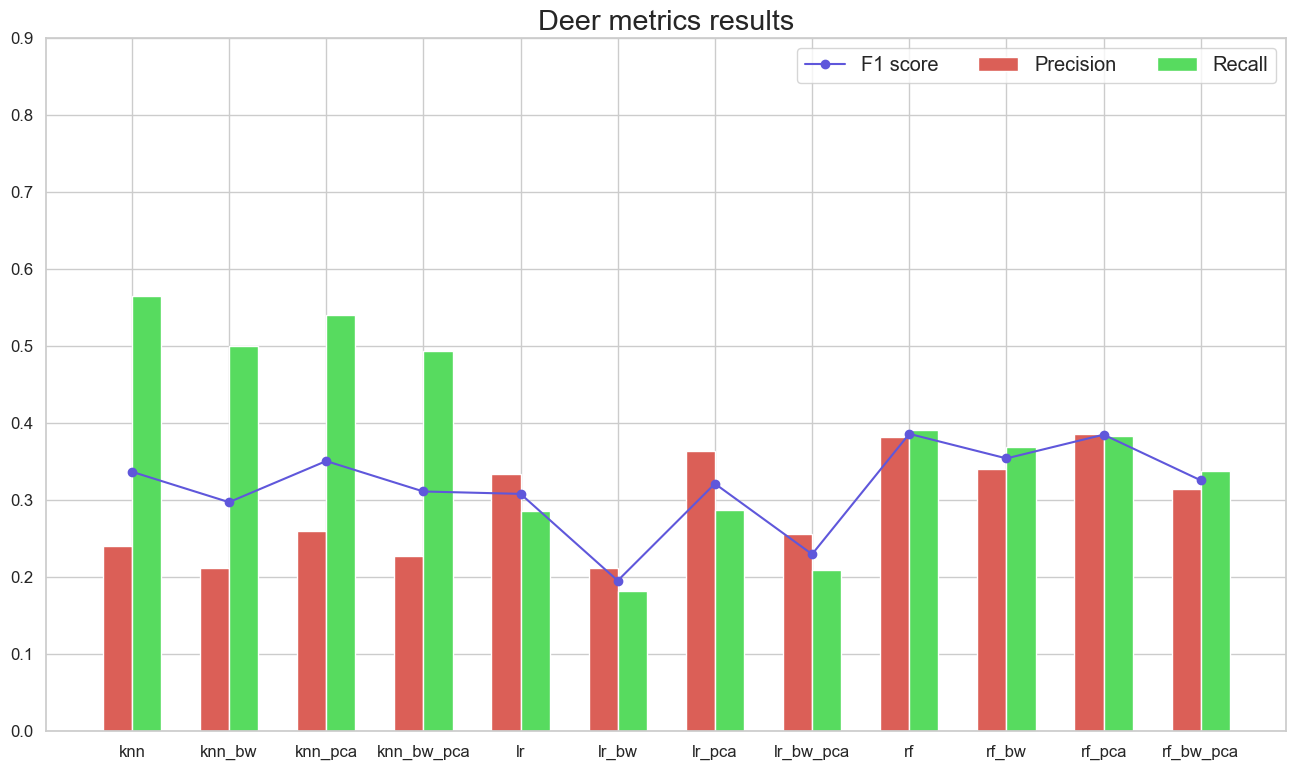

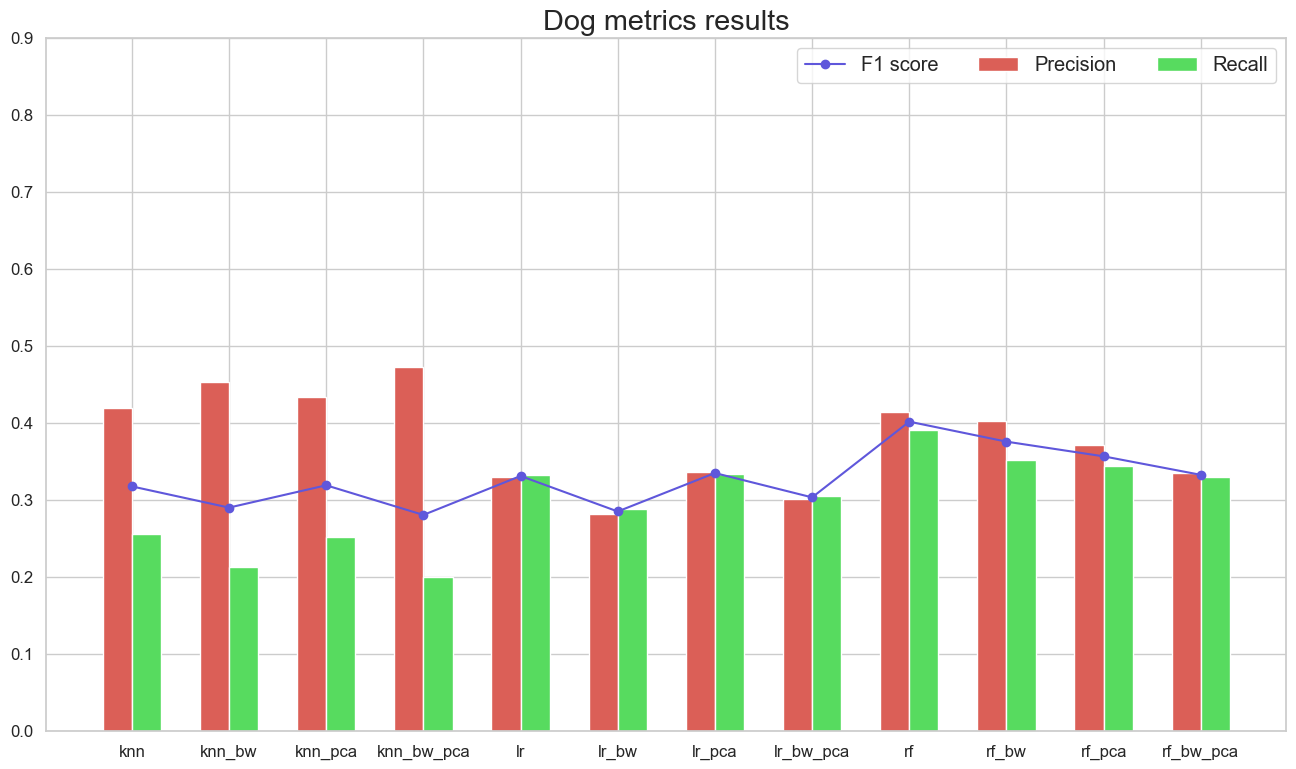

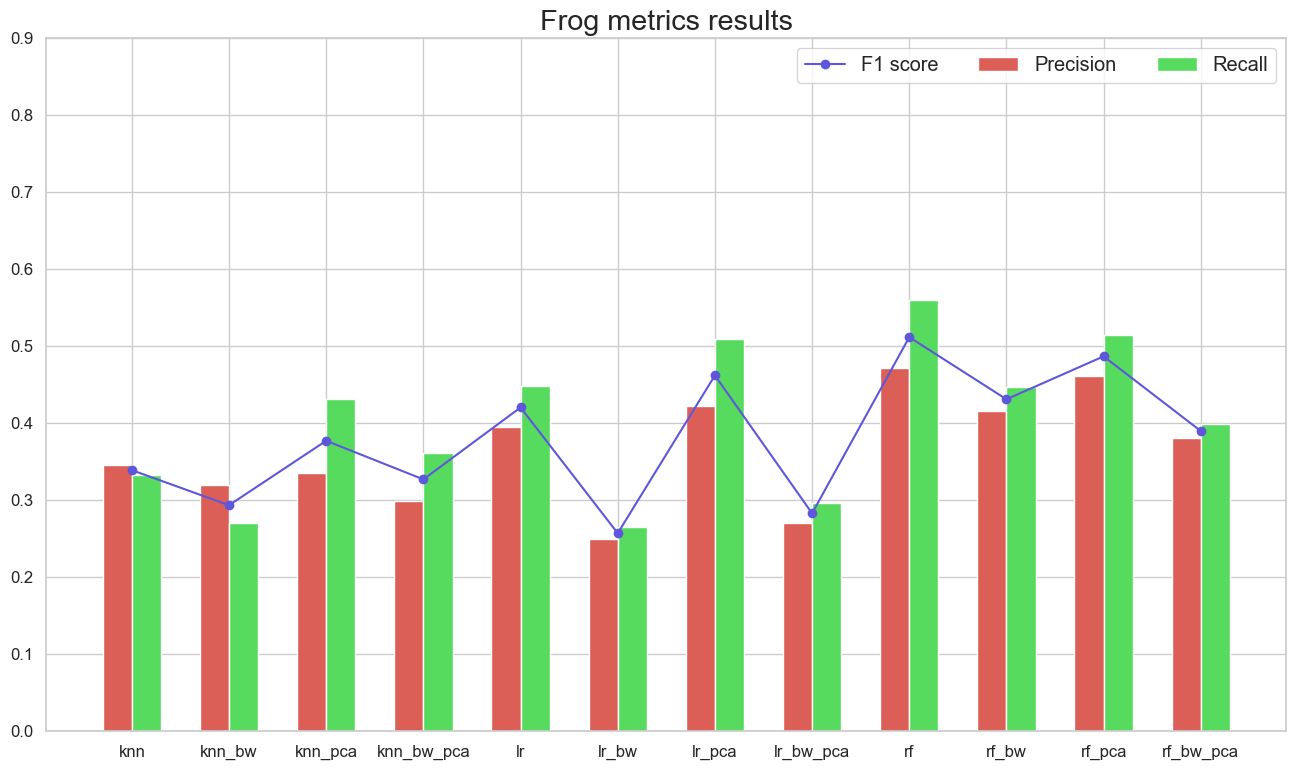

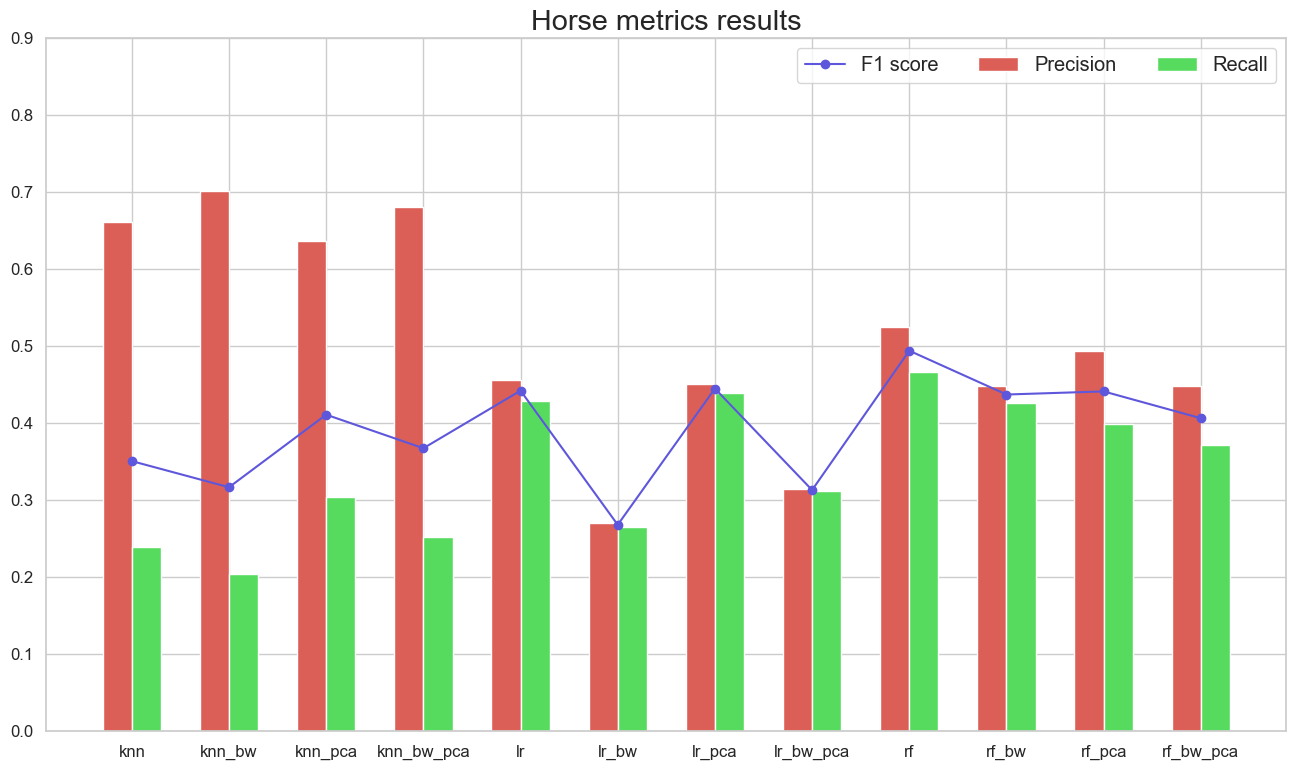

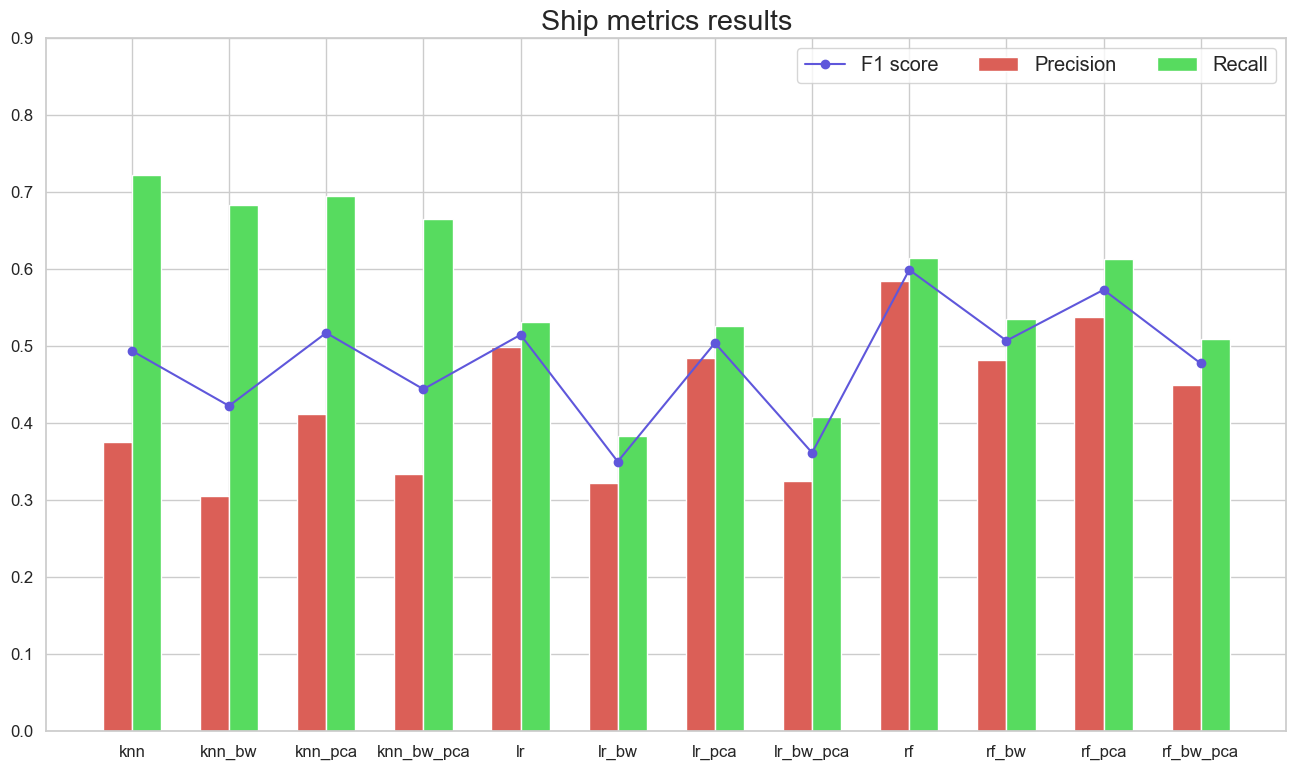

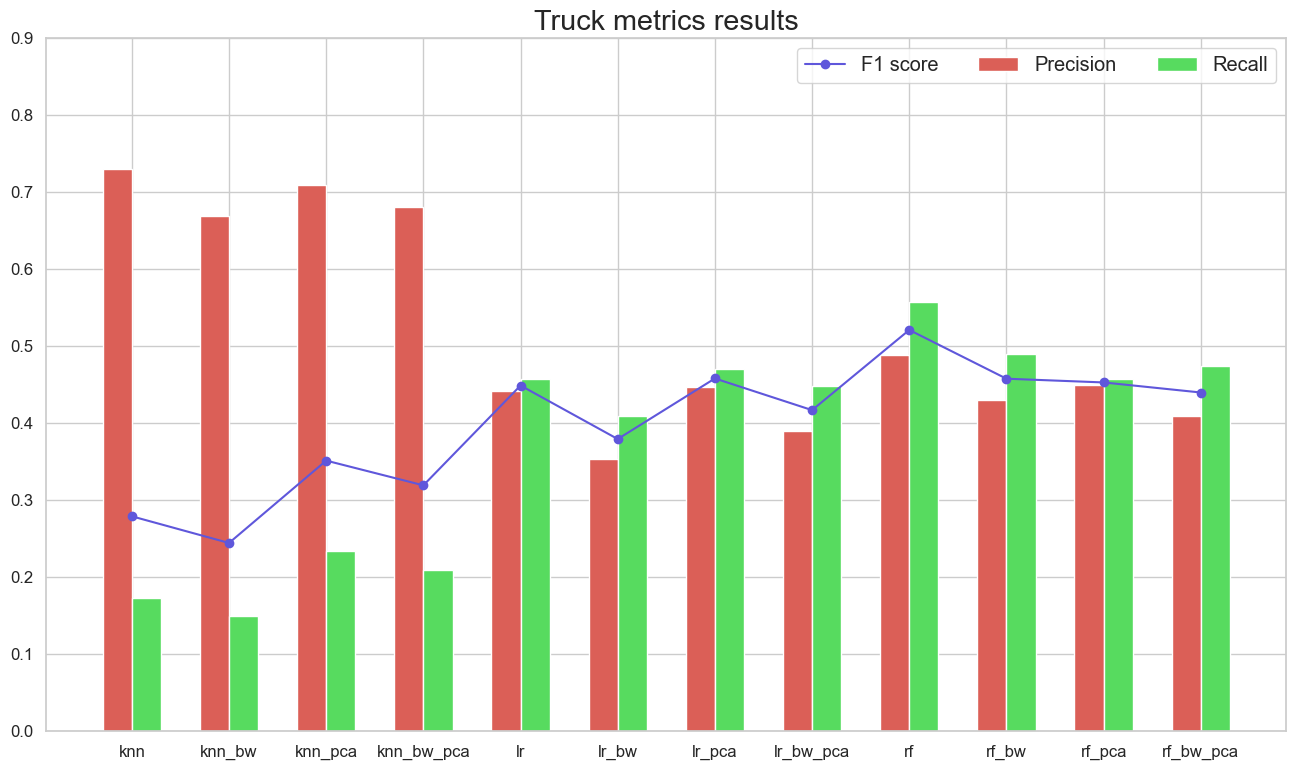

In [12]:
sns.set_style("whitegrid")
palette = sns.color_palette("hls", 3)
sns.set_palette(palette)

category = "airplane"
x = np.arange(len(models_name))
width = 0.30
offset = width/2

for category in cat_dict.keys():
    fig, ax = plt.subplots(figsize=(16, 9))

    precision_values = [cat_dict[category][model]["precision"] for model in models_name]
    recall_values = [cat_dict[category][model]["recall"] for model in models_name]
    f1_score_values = [cat_dict[category][model]["f1_score"] for model in models_name]

    ax.bar(x-offset, precision_values, label="Precision", width=width)
    #ax.bar(x, f1_score_values, label="F1 score", width=width)
    ax.bar(x+offset, recall_values, label="Recall", width=width)
    ax.plot(f1_score_values, color=palette[2], marker="o", label="F1 score")

    ax.set_title(category.title() + " metrics results", fontsize="xx-large")
    ax.set_xticks(x, models_name, fontsize="medium")
    ax.legend(ncol=3, fontsize="large", title_fontsize="x-large")
    ax.set_ylim(0, 0.9)
    plt.setp(ax.get_yticklabels(), fontsize="medium")

plt.show()